In [93]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib import cm
from matplotlib.pyplot import colorbar
from scipy.interpolate import interp2d, Rbf
import matplotlib

In [94]:
X, y = generate_gaussian_parity(1000)
X_ood, y_ood = generate_gaussian_parity(1000, angle_params=np.pi/4)

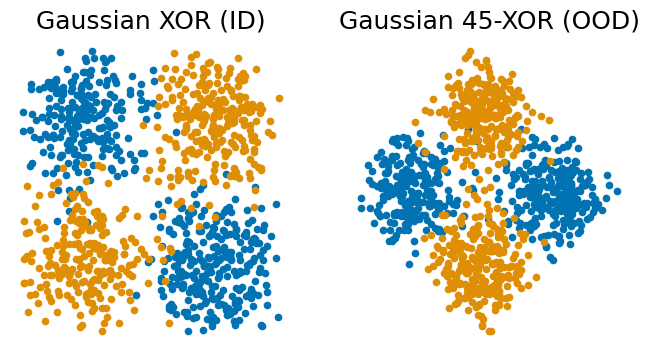

In [95]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood,y_ood, ax=ax[1])

right_side = ax[0].spines["right"]
right_side.set_visible(False)
top_side = ax[0].spines["top"]
top_side.set_visible(False)
left_side = ax[0].spines["left"]
left_side.set_visible(False)
bottom_side = ax[0].spines["bottom"]
bottom_side.set_visible(False)


right_side = ax[1].spines["right"]
right_side.set_visible(False)
top_side = ax[1].spines["top"]
top_side.set_visible(False)
left_side = ax[1].spines["left"]
left_side.set_visible(False)
bottom_side = ax[1].spines["bottom"]
bottom_side.set_visible(False)

ax[0].set_xticks([])
ax[0].set_yticks([])
ax[1].set_xticks([])
ax[1].set_yticks([])

ax[0].set_title('Gaussian XOR (ID)')
ax[1].set_title(r'Gaussian 45-XOR (OOD)')

plt.savefig('simulation.pdf')

In [362]:
n_estimators = 100
n_seeds = 100
splitting_criteria = ['gini', 'entropy', 'log_loss']
n_criteria = len(splitting_criteria)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angles = [0, np.pi/6, np.pi/4, np.pi/2]

In [363]:
def experiment(angle, n_components, stress=False):
    rf_models = [[] for _ in range(n_criteria)]

    np.random.seed(10)
    x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
    x_test_id, y_test_id = generate_gaussian_parity(n_test_id)
    
    x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle)
    x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle)
    
    for i in range(n_criteria):
        for j in range(n_seeds):
            model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=(i+1)*(j+1))
            model.fit(x_train_id, y_train_id)
            rf_models[i].append(model)

    ##########################################################
    l_id = np.zeros((n_criteria, n_seeds), dtype=float)
    l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
    proba = []
    
    for i in (range(n_criteria)):
        for j in range(n_seeds):
            proba.append(
                rf_models[i][j].predict_proba(x_eval_ood)
            )
            y_pred_id = rf_models[i][j].predict(x_test_id)
            y_pred_ood = rf_models[i][j].predict(x_test_ood)
            l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
            l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

    ########################################################
    D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

    for ii in range(n_seeds*n_criteria):
        for jj in range(ii+1, n_seeds*n_criteria):
            D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
            D[jj,ii] = D[ii,jj]

    #######################################################

    embedding = MDS(n_components=n_components, dissimilarity='precomputed', n_init=4, max_iter=100, 
                 verbose=0, eps=0.001, n_jobs=-1, random_state=101)
    X_transformed = embedding.fit_transform(D)

    if stress:
        return X_transformed, l_id, l_ood, embedding.stress_
    else:
        return X_transformed, l_id, l_ood

In [364]:
def plot_embeddings(X_transformed, l_id, l_ood, angle, ax):
    ax.scatter(X_transformed[:100,0], X_transformed[:100,1], l_ood[0], c='k', marker='o', alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0], s=40)
    ax.scatter(X_transformed[100:200,0], X_transformed[100:200,1], l_ood[1], c='r', marker='o', alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1], s=40)
    ax.scatter(X_transformed[200:,0], X_transformed[200:,1], l_ood[2], c='b', marker='o', alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2], s=40)

    ax.set_zlabel('l_ood')
    ax.set_xlabel('X1')
    ax.set_ylabel('X2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])
    

In [365]:
X_transformed, l_id, l_ood = [], [], []
for angle in tqdm(angles):
    X_, l_id_, l_ood_ = experiment(angle, 2)
    X_transformed.append(X_)
    l_id.append(l_id_)
    l_ood.append(l_ood_)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [01:56<00:00, 29.05s/it]


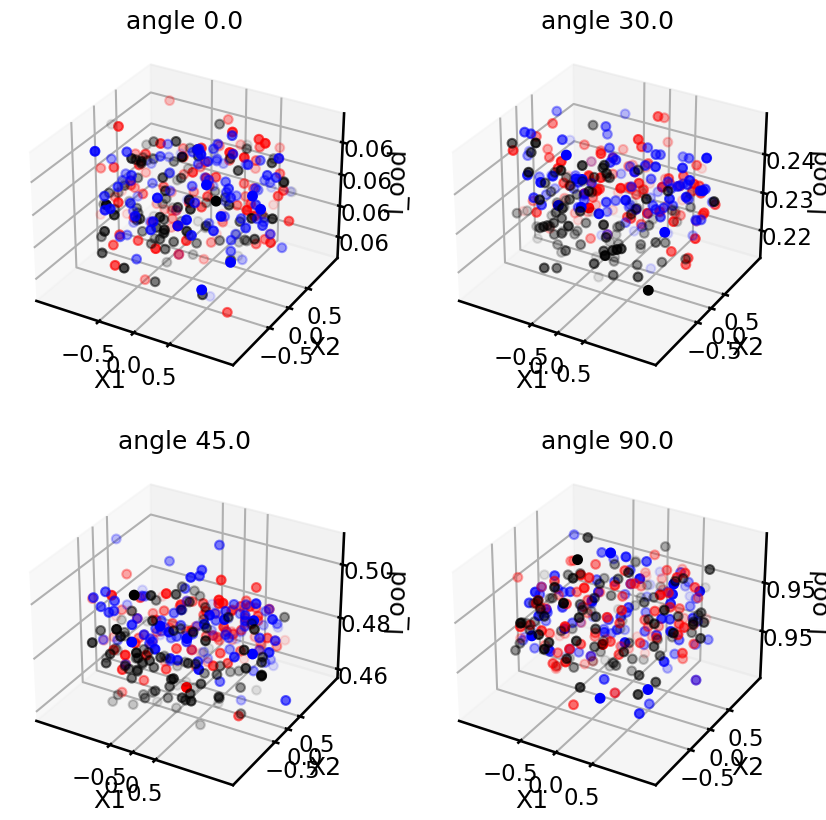

In [366]:
fig = plt.figure(figsize=(10,10))
sns.set_context('talk')

for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    plot_embeddings(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax)

plt.savefig('embeddings.pdf')

In [ ]:
n_components = [1,2,3,4,5,6,7,8,9,10]
stresses = []

for component in tqdm(n_components):
    _, _, _, stress = experiment(np.pi/4, component, stress=True)
    stresses.append(stress)

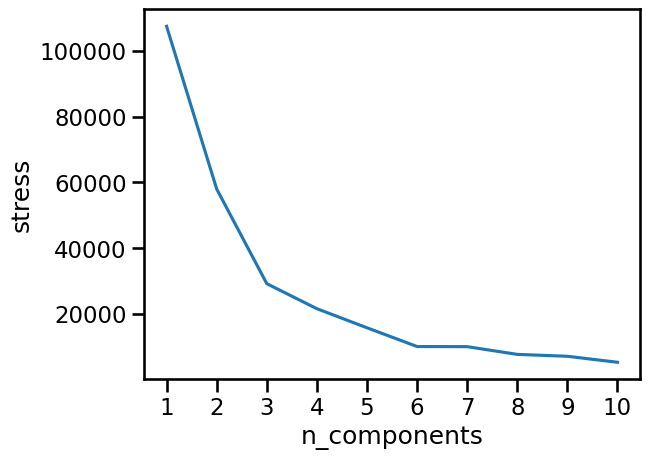

In [550]:
sns.set_context('talk')

plt.plot(n_components, stresses)
plt.xticks(n_components)
plt.xlabel('n_components')
plt.ylabel('stress')
plt.savefig('scree_plot.pdf', bbox_inches='tight')

In [184]:
import pickle

summary = (X_transformed, l_id, l_ood, stresses)

with open('result.pickle','wb') as f:
    pickle.dump(summary, f)

In [3]:
import pickle
with open('result.pickle','rb') as f:
    (X_transformed, l_id, l_ood, stresses) = pickle.load(f)


In [367]:
def plot_embeddings_(X_transformed, l_id, l_ood, angle, ax, min_val, max_val):
    cmap = cm.coolwarm
    l_id = l_id.ravel()
    l_ood = l_ood.ravel()
    
    l_id = (l_id - min_val)/(max_val - min_val)


    min_x1, max_x1 = np.min(X_transformed[:,0]), np.max(X_transformed[:,0])
    min_x2, max_x2 = np.min(X_transformed[:,1]), np.max(X_transformed[:,1])
    X1_grid1 = np.linspace(min_x1, max_x1, 100)
    X2_grid1 = np.linspace(min_x2, max_x2, 100)
    #X1_grid, X2_grid = np.meshgrid(X1_grid, X2_grid)
    X1_grid1, X2_grid1 = np.meshgrid(X1_grid1, X2_grid1)
    
    f = Rbf(X_transformed[:,0], X_transformed[:,1], l_ood, kernel='linear', smoothing=5)
    Z1 = f(X1_grid1, X2_grid1)
    #print(Z1.shape)
    mean_val = np.mean(l_ood)
    var_val = np.var(l_ood)**.5
    zlim = mean_val
    
    for ii in range(100):
        for jj in range(100):
            if Z1[ii,jj] < mean_val - var_val*3 or Z1[ii,jj]>mean_val + var_val*3:
                Z1[ii,jj] = np.nan


    f = Rbf(X_transformed[:,0], X_transformed[:,1], l_id, kernel='linear', smoothing=5)
    l_id1 = f(X1_grid1, X2_grid1)
    mean_val = np.mean(l_id)
    var_val = np.var(l_id)**.5
    
    '''for ii in range(100):
        for jj in range(100):
            if l_id1[ii,jj] < mean_val - var_val*10 or l_id1[ii,jj]>mean_val + var_val*10:
                l_id1[ii,jj] = np.nan'''
    
    
    #####################################################################

    norm = matplotlib.colors.Normalize(vmin=l_id1.min().min(), vmax=l_id1.max().max())
    
    p = ax.plot_surface(X1_grid1, X2_grid1, Z1,
                           linewidth=0, antialiased=False, facecolors=cmap(l_id1), vmin=0, vmax=1)


   # matplotlib.colorbar.ColorbarBase(p, ax=ax)
    
    norm = matplotlib.colors.Normalize(vmin=l_id.min().min(), vmax=l_id.max().max())
    ax.scatter(X_transformed[:100,0], X_transformed[:100,1], zlim-.08, marker='*', c=cmap(l_id[:100]))
    ax.scatter(X_transformed[100:200,0], X_transformed[100:200,1], zlim-.08, marker='v', c=cmap(l_id[100:200]))
    ax.scatter(X_transformed[200:,0], X_transformed[200:,1], zlim-.08, marker='o', c=cmap(l_id[200:]))
    ax.set_zlim([zlim-.1,zlim+.05])
    ax.set_zlabel('l_ood', fontsize=15)
    ax.set_xlabel('Latent dim 1')
    ax.set_ylabel('Latent dim 2')
    ax.zaxis.set_major_formatter('{x:.02f}')
    ax.set_title('angle ' + str(np.round(angle*180/np.pi,1)))
    ax.set_xticks([-0.5,0,0.5])
    ax.set_yticks([-0.5,0,0.5])
    
    #ax.view_init(-140, 60) 
    ax.view_init(elev=20, azim=-155, roll=0)
    #matplotlib.colorbar.ColorbarBase(p, ax=ax)
    
    return p

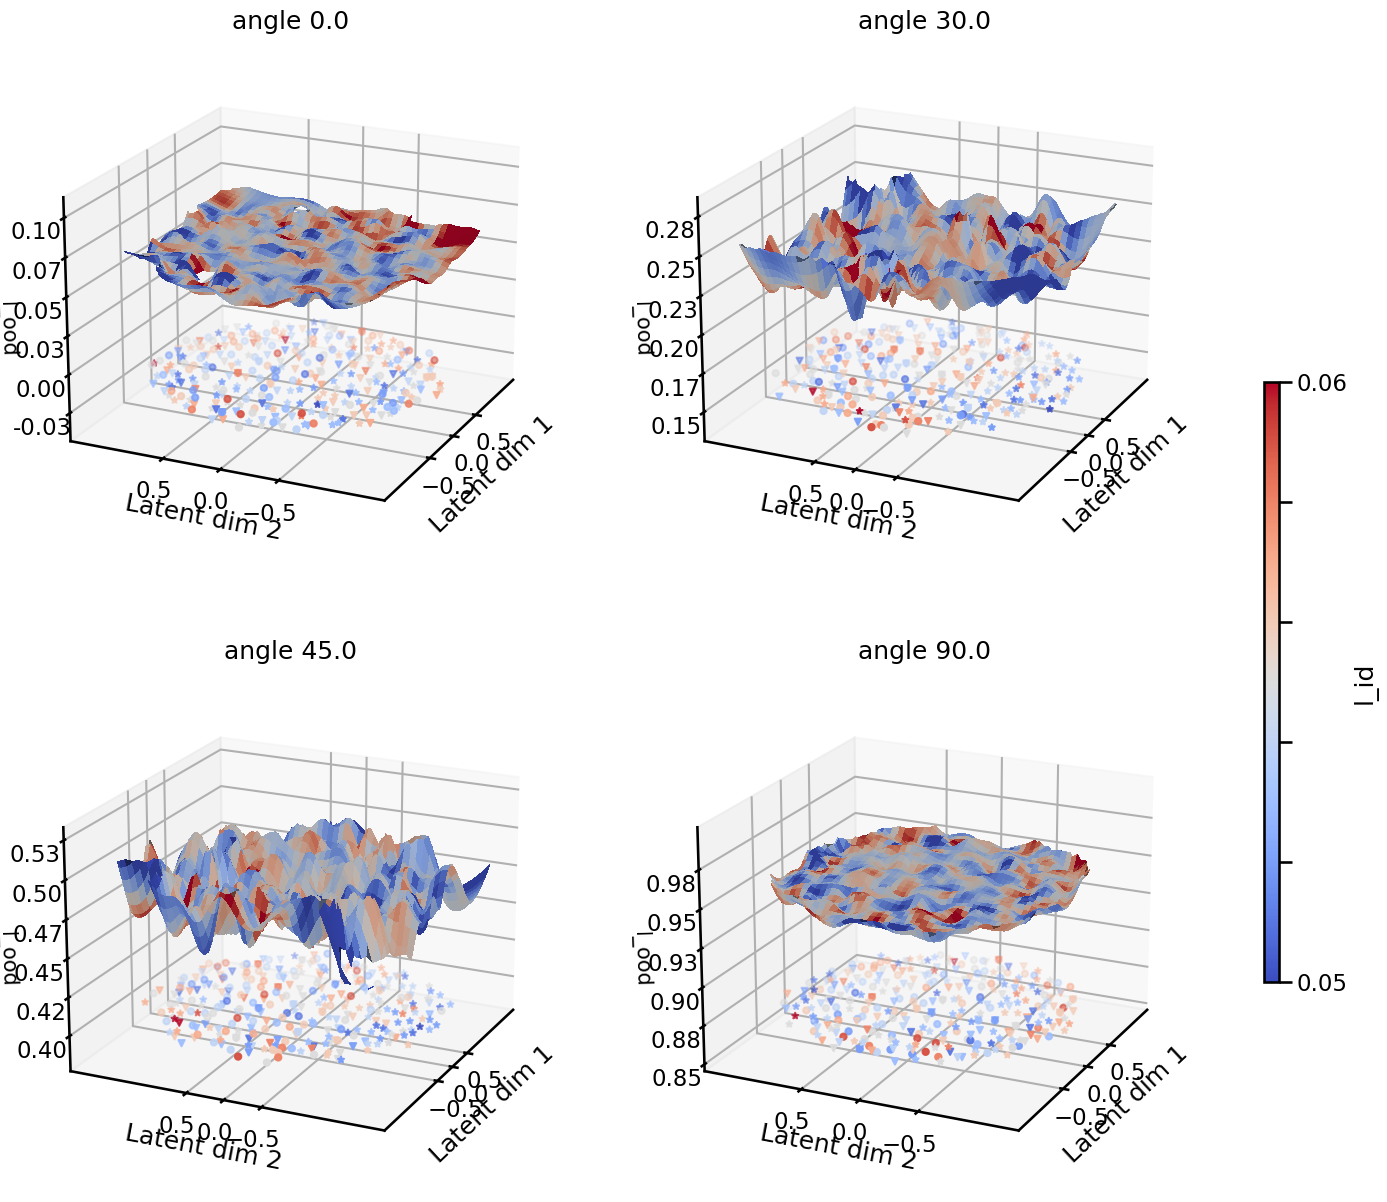

In [368]:
fig = plt.figure(figsize=(15,15), facecolor='white')
sns.set_context('talk')

min_val = np.inf
max_val = -np.inf

for lid in l_id:
    min_val = min(min_val, np.min(lid))
    max_val = max(max_val, np.max(lid))
    
for ii, angle in enumerate(angles):
    ax = fig.add_subplot(2,2,ii+1, projection='3d')
    surf = plot_embeddings_(X_transformed[ii], l_id[ii], l_ood[ii], angle, ax, min_val, max_val)
    #plt.colorbar(surf, ax=ax)

sm = plt.cm.ScalarMappable(norm=plt.Normalize(vmin=0, vmax=1), cmap=cm.coolwarm)
cbaxes = fig.add_axes([.95, 0.25, 0.01, 0.4])
cbar = fig.colorbar(sm, cbaxes, label='l_id')
cbar.ax.set_yticklabels([str(np.round(min_val,2)), '', '', '', '', str(np.round(max_val,2))])

plt.savefig('embeddings_.pdf', bbox_inches='tight')

In [103]:
l_id

[array([[0.058, 0.059, 0.061, 0.06 , 0.056, 0.062, 0.057, 0.058, 0.06 ,
         0.056, 0.06 , 0.061, 0.058, 0.059, 0.058, 0.058, 0.06 , 0.06 ,
         0.059, 0.059, 0.057, 0.058, 0.06 , 0.059, 0.06 , 0.059, 0.059,
         0.061, 0.061, 0.06 , 0.059, 0.061, 0.057, 0.059, 0.058, 0.057,
         0.058, 0.059, 0.06 , 0.057, 0.06 , 0.059, 0.06 , 0.056, 0.055,
         0.059, 0.057, 0.061, 0.06 , 0.058, 0.06 , 0.059, 0.057, 0.059,
         0.06 , 0.057, 0.062, 0.059, 0.059, 0.057, 0.058, 0.06 , 0.059,
         0.059, 0.056, 0.062, 0.058, 0.057, 0.059, 0.059, 0.061, 0.055,
         0.059, 0.06 , 0.056, 0.062, 0.054, 0.056, 0.061, 0.056, 0.059,
         0.058, 0.056, 0.057, 0.062, 0.059, 0.06 , 0.059, 0.06 , 0.057,
         0.057, 0.059, 0.06 , 0.057, 0.056, 0.06 , 0.055, 0.058, 0.058,
         0.056],
        [0.059, 0.061, 0.06 , 0.06 , 0.055, 0.06 , 0.059, 0.06 , 0.059,
         0.057, 0.061, 0.06 , 0.059, 0.065, 0.06 , 0.061, 0.059, 0.064,
         0.06 , 0.061, 0.056, 0.057, 0.062, 0.0

In [104]:
l_ood

[array([[0.04 , 0.041, 0.042, 0.041, 0.038, 0.042, 0.04 , 0.041, 0.041,
         0.041, 0.041, 0.042, 0.039, 0.041, 0.04 , 0.043, 0.043, 0.042,
         0.042, 0.041, 0.038, 0.04 , 0.04 , 0.041, 0.044, 0.042, 0.039,
         0.042, 0.042, 0.041, 0.04 , 0.041, 0.041, 0.043, 0.039, 0.04 ,
         0.039, 0.043, 0.042, 0.039, 0.043, 0.04 , 0.04 , 0.037, 0.039,
         0.041, 0.042, 0.041, 0.038, 0.043, 0.044, 0.041, 0.04 , 0.042,
         0.041, 0.039, 0.04 , 0.04 , 0.041, 0.04 , 0.04 , 0.04 , 0.042,
         0.043, 0.04 , 0.042, 0.04 , 0.038, 0.042, 0.042, 0.039, 0.04 ,
         0.041, 0.04 , 0.039, 0.04 , 0.038, 0.036, 0.042, 0.04 , 0.04 ,
         0.041, 0.041, 0.041, 0.042, 0.04 , 0.043, 0.04 , 0.043, 0.037,
         0.039, 0.04 , 0.038, 0.037, 0.039, 0.041, 0.038, 0.042, 0.039,
         0.04 ],
        [0.043, 0.04 , 0.043, 0.04 , 0.037, 0.043, 0.043, 0.043, 0.043,
         0.041, 0.041, 0.044, 0.041, 0.042, 0.042, 0.041, 0.04 , 0.044,
         0.042, 0.04 , 0.04 , 0.039, 0.044, 0.0

In [208]:
min_val

0.039000000000000035

In [209]:
max_val

0.06299999999999994

In [35]:
X_transformed[0].shape

(300, 2)

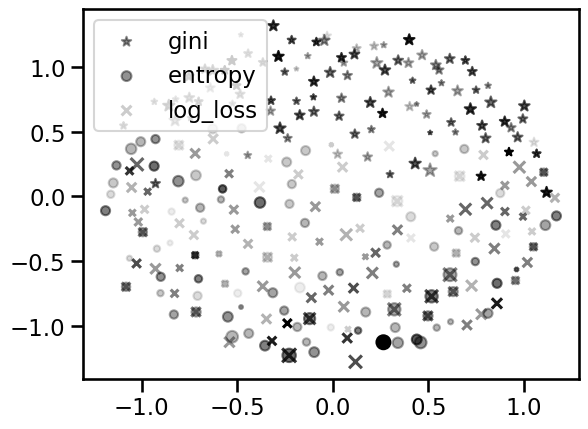

In [126]:
sns.set_context('talk')

plt.scatter(X_transformed[0][:100,0], X_transformed[0][:100,1], c='k', marker='*', s=100*(l_ood[0][0]-np.min(l_ood[0][0]))/(np.max(l_ood[0][0])-np.min(l_ood[0][0])), alpha=(l_id[0][0]-np.min(l_id[0][0]))/(np.max(l_id[0][0])-np.min(l_id[0][0])), label=splitting_criteria[0])
plt.scatter(X_transformed[0][100:200,0], X_transformed[0][100:200,1], c='k', marker='o', s=100*(l_ood[0][1]-np.min(l_ood[0][1]))/(np.max(l_ood[0][1])-np.min(l_ood[0][1])), alpha=(l_id[0][1]-np.min(l_id[0][1]))/(np.max(l_id[0][1])-np.min(l_id[0][1])), label=splitting_criteria[1])
plt.scatter(X_transformed[0][200:,0], X_transformed[0][200:,1], c='k', marker='x', s=100*(l_ood[0][2]-np.min(l_ood[0][2]))/(np.max(l_ood[0][2])-np.min(l_ood[0][2])), alpha=(l_id[0][2]-np.min(l_id[0][2]))/(np.max(l_id[0][2])-np.min(l_id[0][2])), label=splitting_criteria[2])
plt.legend(loc='upper left')

           

In [38]:
rf_models = [[] for _ in range(n_criteria)]

x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
x_test_id, y_test_id = generate_gaussian_parity(n_test_id)

x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=np.pi/6)
x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=np.pi/6)

for i in tqdm(range(n_criteria)):
    for j in range(n_seeds):
        model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=j)
        model.fit(x_train_id, y_train_id)
        rf_models[i].append(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:47<00:00, 35.76s/it]


In [39]:
l_id = np.zeros((n_criteria, n_seeds), dtype=float)
l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
proba = []

for i in tqdm(range(n_criteria)):
    for j in range(n_seeds):
        proba.append(
            rf_models[i][j].predict_proba(x_eval_ood)
        )
        y_pred_id = rf_models[i][j].predict(x_test_id)
        y_pred_ood = rf_models[i][j].predict(x_test_ood)
        l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
        l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:27<00:00,  9.05s/it]


In [40]:
D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

for ii in tqdm(range(n_seeds*n_criteria)):
    for jj in range(ii+1, n_seeds*n_criteria):
        D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
        D[jj,ii] = D[ii,jj]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1767.36it/s]


In [41]:
embedding = MDS(n_components=2, dissimilarity='precomputed')
X_transformed = embedding.fit_transform(D)

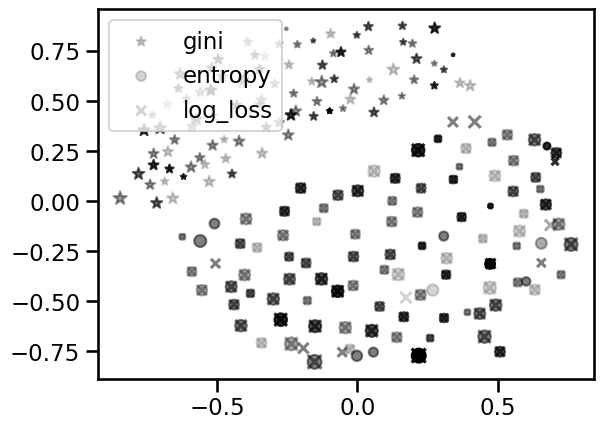

In [42]:
sns.set_context('talk')

plt.scatter(X_transformed[:100,0], X_transformed[:100,1], c='k', marker='*', s=100*(l_ood[0]-np.min(l_ood[0]))/(np.max(l_ood[0])-np.min(l_ood[0])), alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0])
plt.scatter(X_transformed[100:200,0], X_transformed[100:200,1], c='k', marker='o', s=100*(l_ood[1]-np.min(l_ood[1]))/(np.max(l_ood[1])-np.min(l_ood[1])), alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1])
plt.scatter(X_transformed[200:,0], X_transformed[200:,1], c='k', marker='x', s=100*(l_ood[2]-np.min(l_ood[2]))/(np.max(l_ood[2])-np.min(l_ood[2])), alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2])
plt.legend(loc='upper left')

In [185]:
from sklearn.ensemble import RandomForestClassifier as rf
from kdg.utils import generate_gaussian_parity, plot_2dsim
from tqdm import tqdm
import numpy as np
from sklearn.manifold import MDS
import matplotlib.pyplot as plt
import seaborn as sns

In [186]:

X, y = generate_gaussian_parity(1000)
X_ood, y_ood = generate_gaussian_parity(1000, angle_params=np.pi/6)

<AxesSubplot: >

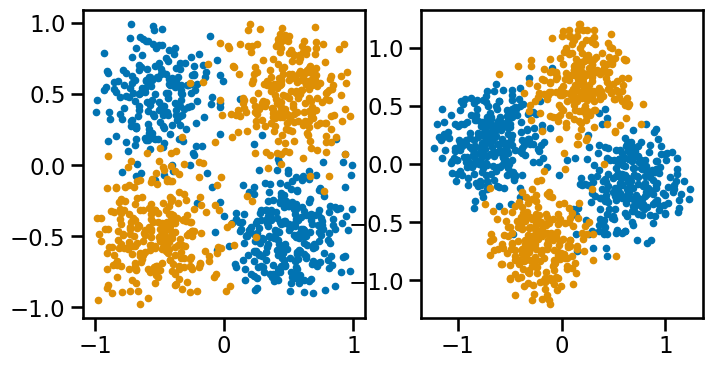

In [187]:
fig, ax = plt.subplots(1,2,figsize=(8,4))

plot_2dsim(X,y, ax=ax[0])
plot_2dsim(X_ood,y_ood, ax=ax[1])


In [297]:
n_estimators = 500
n_seeds = 100
splitting_criteria = ['gini', 'entropy', 'log_loss']
n_criteria = len(splitting_criteria)
n_train_id = 1000
n_test_id = 1000
n_eval_ood = 1000
n_test_ood = 1000
angle = 0

In [298]:
rf_models = [[] for _ in range(n_criteria)]

#np.random.seed(10)
x_train_id, y_train_id = generate_gaussian_parity(n_train_id)
x_test_id, y_test_id = generate_gaussian_parity(n_test_id)

x_eval_ood, y_eval_ood = generate_gaussian_parity(n_eval_ood, angle_params=angle)
x_test_ood, y_test_ood = generate_gaussian_parity(n_test_ood, angle_params=angle)

for i in tqdm(range(n_criteria)):
    for j in range(n_seeds):
        model = rf(n_estimators=n_estimators, criterion=splitting_criteria[i], random_state=(i+1)*(j+1))
        model.fit(x_train_id, y_train_id)
        rf_models[i].append(model)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [01:44<00:00, 34.94s/it]


In [299]:
l_id = np.zeros((n_criteria, n_seeds), dtype=float)
l_ood = np.zeros((n_criteria, n_seeds), dtype=float)
proba = []

for i in tqdm(range(n_criteria)):
    for j in range(n_seeds):
        proba.append(
            rf_models[i][j].predict_proba(x_eval_ood)
        )
        y_pred_id = rf_models[i][j].predict(x_test_id)
        y_pred_ood = rf_models[i][j].predict(x_test_ood)
        l_id[i,j] = 1 - np.mean(y_test_id==y_pred_id)
        l_ood[i,j] = 1 - np.mean(y_test_ood==y_pred_ood)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:25<00:00,  8.54s/it]


In [300]:
D = np.zeros((n_seeds*n_criteria, n_seeds*n_criteria), dtype=float)

for ii in tqdm(range(n_seeds*n_criteria)):
    for jj in range(ii+1, n_seeds*n_criteria):
        D[ii,jj] = np.sum((proba[ii]-proba[jj])**2)**.5
        D[jj,ii] = D[ii,jj]

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 300/300 [00:00<00:00, 1755.48it/s]


In [336]:
embedding = MDS(n_components=2, dissimilarity='precomputed', n_init=2, max_iter=100, 
                 verbose=0, eps=0.001, n_jobs=2, random_state=101)
X_transformed = embedding.fit_transform(D)

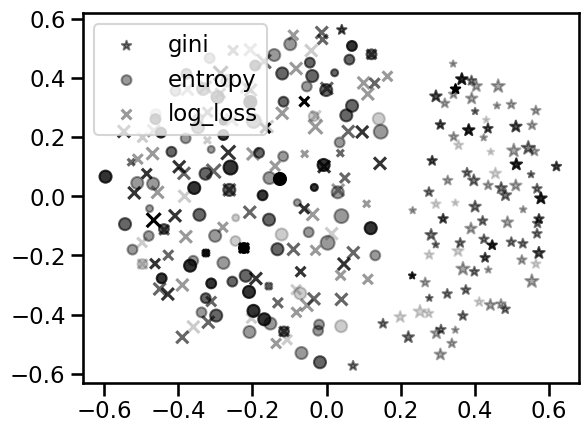

In [337]:
sns.set_context('talk')

plt.scatter(X_transformed[:100,0], X_transformed[:100,1], c='k', marker='*', s=100*(l_ood[0]-np.min(l_ood[0]))/(np.max(l_ood[0])-np.min(l_ood[0])), alpha=(l_id[0]-np.min(l_id[0]))/(np.max(l_id[0])-np.min(l_id[0])), label=splitting_criteria[0])
plt.scatter(X_transformed[100:200,0], X_transformed[100:200,1], c='k', marker='o', s=100*(l_ood[1]-np.min(l_ood[1]))/(np.max(l_ood[1])-np.min(l_ood[1])), alpha=(l_id[1]-np.min(l_id[1]))/(np.max(l_id[1])-np.min(l_id[1])), label=splitting_criteria[1])
plt.scatter(X_transformed[200:,0], X_transformed[200:,1], c='k', marker='x', s=100*(l_ood[2]-np.min(l_ood[2]))/(np.max(l_ood[2])-np.min(l_ood[2])), alpha=(l_id[2]-np.min(l_id[2]))/(np.max(l_id[2])-np.min(l_id[2])), label=splitting_criteria[2])
plt.legend(loc='upper left')

           

In [311]:
embedding.embedding_

array([[ 0.42698453,  0.17785163],
       [ 0.37276514,  0.05422945],
       [ 0.44605898,  0.21175104],
       [ 0.55147008, -0.14929014],
       [ 0.49417859,  0.08121459],
       [ 0.39511879,  0.45266547],
       [ 0.61872937,  0.08654248],
       [ 0.46016534,  0.31703849],
       [ 0.31342269, -0.46867496],
       [ 0.52100924, -0.21644295],
       [ 0.40994323, -0.32300425],
       [ 0.29051217, -0.06017054],
       [ 0.44405096,  0.37884139],
       [ 0.46696225, -0.33430686],
       [ 0.52384013,  0.22074731],
       [ 0.34050549,  0.29381794],
       [ 0.24564099, -0.359651  ],
       [ 0.61184399, -0.12996407],
       [ 0.44281038, -0.12430699],
       [ 0.42241599, -0.23979762],
       [ 0.32481067,  0.25100351],
       [ 0.27962798, -0.41603633],
       [ 0.59742708, -0.10122691],
       [ 0.25129352, -0.22576646],
       [ 0.59870066, -0.03421838],
       [ 0.38553663,  0.27446532],
       [ 0.4612304 ,  0.00253046],
       [ 0.40150121, -0.10172832],
       [ 0.30588973,

In [235]:
X_transformed

array([[-0.06333411, -0.13469963, -0.27349812, -0.19991188],
       [-0.15048981, -0.27680836, -0.30727663, -0.11966607],
       [-0.18338411, -0.21953681, -0.38166202,  0.12283755],
       ...,
       [-0.2374555 , -0.17869683,  0.30478392, -0.03869522],
       [-0.18132945, -0.13680697,  0.26641203,  0.12148776],
       [-0.16046602,  0.2622852 , -0.08687978, -0.0641338 ]])

In [292]:
embedding.stress_

3819.6310321234023